# django-postgre-copy speed tests

By Ben Welsh

This notebook tests the effect of dropping database constraints and indexes prior to loading a large data file.

The official PostgreSQL documentation suggests it lead to significant gains.

We will test this claim by dropping constraints and indexes prior to loading data from the California Civic Data Coalition via the django-postgres-copy wrapper on the database's COPY command.

### Connect California Civic Data Coalition Django project

Import Python tools

In [98]:
import os
import sys
import csv
import calculate
import scipy as sp
import pandas as pd
import scipy.optimize
from pprint import pprint
import matplotlib as mpl
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as patches

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
import logging
logger = logging.getLogger('postgres_copy')
logger.addHandler(logging.NullHandler())
logger.propagate = False

In [38]:
mpl.style.use('seaborn-paper')

In [4]:
%matplotlib inline

Add the Django settings module to the environment.

In [4]:
sys.path.insert(0, '/home/palewire/.virtualenvs/django-calaccess-raw-data/src/')
sys.path.insert(0, '/home/palewire/.virtualenvs/django-calaccess-raw-data/lib/python2.7/')
sys.path.insert(0, '/home/palewire/.virtualenvs/django-calaccess-raw-data/lib/python2.7/site-packages/')
sys.path.insert(0, '/home/palewire/Code/django-calaccess-raw-data/')
sys.path.insert(0, '/home/palewire/Code/django-calaccess-raw-data/example/')
sys.path.insert(0, '/home/palewire/Code/django-postgres-copy/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "settings")

'settings'

Verify we have the correct version of django-postgres-copy

In [5]:
import postgres_copy

In [6]:
postgres_copy.__version__

'2.1.0'

Boot the Django project

In [7]:
%%capture
import django
django.setup()

### Prep for speed tests

Download raw data we will test

In [8]:
!curl -O https://calaccess.download/latest/raw.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  842M  100  842M    0     0  11.2M      0  0:01:15  0:01:15 --:--:-- 11.1M


In [11]:
!rm *.csv

In [12]:
!unzip raw.zip

Archive:  raw.zip
  inflating: lookup_codes_cd.csv     
  inflating: filer_type_periods_cd.csv  
  inflating: filer_ethics_class_cd.csv  
  inflating: hdr_cd.csv              
  inflating: cvr_campaign_disclosure_cd.csv  
  inflating: filings_cd.csv          
  inflating: filing_period_cd.csv    
  inflating: lobbyist_firm2_cd.csv   
  inflating: lobbyist_firm_employer1_cd.csv  
  inflating: lobbyist_employer_firms2_cd.csv  
  inflating: filer_filings_cd.csv    
  inflating: lccm_cd.csv             
  inflating: s498_cd.csv             
  inflating: loan_cd.csv             
  inflating: lobbyist_firm_history_cd.csv  
  inflating: filers_cd.csv           
  inflating: lobbyist_employer_history_cd.csv  
  inflating: cvr_registration_cd.csv  
  inflating: s497_cd.csv             
  inflating: filername_cd.csv        
  inflating: group_types_cd.csv      
  inflating: header_cd.csv           
  inflating: filer_types_cd.csv      
  inflating: filer_to_filer_type_cd.csv  
  inflating: expn_

Import database models

In [29]:
import calaccess_raw
from calaccess_raw import models 

In [30]:
def truncate(model):
    from django.db import connection
    cursor = connection.cursor()
    cursor.execute('TRUNCATE TABLE "{}";'.format(model._meta.db_table))

In [37]:
# Set a blank list to store the results
result_list = []

# Loop through the models and run the tests
for model in calaccess_raw.get_model_list():
    print "Testing {}".format(model.__name__)

    # Find the CSV for the model
    csv_name = model().get_csv_name()
    if not os.path.exists(csv_name):
        print("No csv. Skipping.")
        continue
    
    # Count its rows
    raw_rows = !wc -l $csv_name
    rows = int(raw_rows[0].split()[0])
    if not rows > 0:
        print("No data. Skipping.")
        continue

    # Map the CSV to the model
    mapping = dict(
        (f.name, f.db_column) for f in model._meta.fields
        if f.db_column
    )
    
    # Set the test function
    f = model.objects.from_csv
    
    # Test it with dropped indexes
    drop_kwargs = dict(drop_constraints=True, drop_indexes=True)
    drop = %%timeit -r 3 -oq truncate(model); f(csv_name, mapping, **drop_kwargs)

    # Test it without dropped indexes
    dont_kwargs = dict(drop_constraints=False, drop_indexes=False)
    dont_drop = %%timeit -r 3 -oq truncate(model); f(csv_name, mapping, **dont_kwargs)

    # Return the results
    result = {
        'model_name': model.__name__,
        'rows': rows,
        'indexed_fields': len(model.objects.indexed_fields),
        'constrained_fields': len(model.objects.constrained_fields),
        'dont_drop': dont_drop.best,
        'drop': drop.best
    }
    pprint(result)
    result_list.append(result)

Testing CvrSoCd
{'constrained_fields': 0,
 'dont_drop': 0.849437952041626,
 'drop': 0.8597939014434814,
 'indexed_fields': 4,
 'model_name': 'CvrSoCd',
 'rows': 17229}
Testing Cvr2SoCd
{'constrained_fields': 0,
 'dont_drop': 1.2699148654937744,
 'drop': 0.9175539016723633,
 'indexed_fields': 4,
 'model_name': 'Cvr2SoCd',
 'rows': 44246}
Testing CvrCampaignDisclosureCd
{'constrained_fields': 0,
 'dont_drop': 22.158819913864136,
 'drop': 17.549975872039795,
 'indexed_fields': 4,
 'model_name': 'CvrCampaignDisclosureCd',
 'rows': 404280}
Testing Cvr2CampaignDisclosureCd
{'constrained_fields': 0,
 'dont_drop': 3.251678943634033,
 'drop': 2.517705202102661,
 'indexed_fields': 4,
 'model_name': 'Cvr2CampaignDisclosureCd',
 'rows': 110189}
Testing Cvr3VerificationInfoCd
{'constrained_fields': 0,
 'dont_drop': 5.926052093505859,
 'drop': 3.4498190879821777,
 'indexed_fields': 5,
 'model_name': 'Cvr3VerificationInfoCd',
 'rows': 252547}
Testing DebtCd
{'constrained_fields': 0,
 'dont_drop': 13.

{'constrained_fields': 0,
 'dont_drop': 6.585654020309448,
 'drop': 4.463361024856567,
 'indexed_fields': 5,
 'model_name': 'LexpCd',
 'rows': 202013}
Testing LccmCd
{'constrained_fields': 0,
 'dont_drop': 2.635312080383301,
 'drop': 1.8452649116516113,
 'indexed_fields': 5,
 'model_name': 'LccmCd',
 'rows': 96361}
Testing LpayCd
{'constrained_fields': 0,
 'dont_drop': 16.043572902679443,
 'drop': 10.699281930923462,
 'indexed_fields': 5,
 'model_name': 'LpayCd',
 'rows': 499442}
Testing LothCd
{'constrained_fields': 0,
 'dont_drop': 0.45551609992980957,
 'drop': 0.42151689529418945,
 'indexed_fields': 5,
 'model_name': 'LothCd',
 'rows': 15564}
Testing FilernameCd
{'constrained_fields': 0,
 'dont_drop': 22.1668860912323,
 'drop': 13.79504108428955,
 'indexed_fields': 4,
 'model_name': 'FilernameCd',
 'rows': 787995}
Testing FilerFilingsCd
{'constrained_fields': 0,
 'dont_drop': 66.93545007705688,
 'drop': 43.47457003593445,
 'indexed_fields': 6,
 'model_name': 'FilerFilingsCd',
 'rows

In [5]:
outfile = csv.DictWriter(
    open("speed-test.csv", 'w'),
    result_list[0].keys()
)
outfile.writeheader()
outfile.writerows(result_list)

NameError: name 'result_list' is not defined

### Analyze the results

In [8]:
df = pd.read_csv("speed-test.csv")

What we loaded

In [9]:
print "Tables: {:,}".format(len(df))
print "Rows: {:,}".format(df.rows.sum())

Tables: 63
Rows: 41,739,719


How long it took in seconds

In [10]:
print "Without drops: {:,.0f} seconds".format(df.dont_drop.sum())
print "With drops: {:,.0f} seconds".format(df['drop'].sum())

Without drops: 1,269 seconds
With drops: 871 seconds


How long it took in minutes

In [11]:
print "Without drops: {:.0f} minutes, {:.0f} seconds".format(*divmod(df.dont_drop.sum(), 60))
print "With drops: {:.0f} minutes, {:.0f} seconds".format(*divmod(df['drop'].sum(), 60))

Without drops: 21 minutes, 9 seconds
With drops: 14 minutes, 31 seconds


The change

In [12]:
print "Absolute change: {:.0f} minutes, {:,.0f} seconds".format(*divmod(df['dont_drop'].sum() - df['drop'].sum(), 60))
print "Percent change: {:,.0f}%".format(((df['drop'].sum() - df.dont_drop.sum())/df['dont_drop'].sum())*100)

Absolute change: 6 minutes, 38 seconds
Percent change: -31%


Charge the changes by table size

In [13]:
df['change'] = df['dont_drop'] - df['drop']

In [14]:
df['percent_change'] = (df['drop'] - df['dont_drop']) / df['dont_drop']

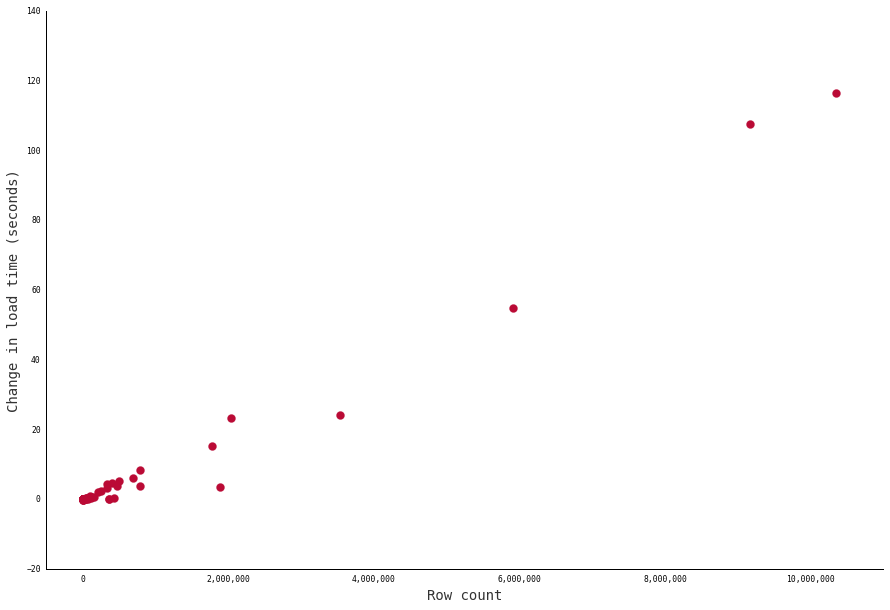

In [150]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Row count", fontsize=14, color="#333333")
ax.set_ylabel("Change in load time (seconds)", fontsize=14, color="#333333")
ax.scatter(df.rows, df.change, color="#ba0a35", s=65)
plt.xlim(-500000, plt.xlim()[1]-1000000)
plt.tick_params(
    axis='both',
    which='both',
    bottom='off',
    top='off',
    left="off",
    right="off"
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)
plt.show()

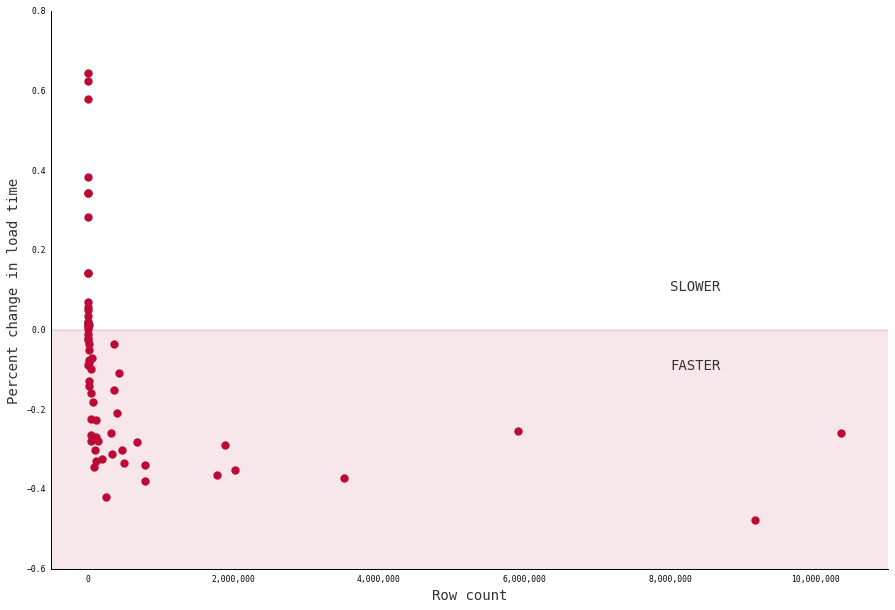

In [146]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Row count", fontsize=14, color="#333333")
ax.set_ylabel("Percent change in load time", fontsize=14, color="#333333")
ax.scatter(df.rows, df.percent_change, color="#ba0a35", s=65)
plt.xlim(-500000, plt.xlim()[1]-1000000)
plt.axhline(0, lw=0.2, color="#ba0a35")
plt.annotate("FASTER", (8000000, -0.1), fontsize=14, color="#333333")
plt.annotate("SLOWER", (8000000, 0.1), fontsize=14, color="#333333")
ax.add_patch(
    patches.Rectangle(
        (plt.xlim()[0], 0),
        plt.xlim()[1] + 500000,
        plt.ylim()[0],
        color="#ba0a35",
        alpha=0.1
    )
)
plt.tick_params(
    axis='both',
    which='both',
    bottom='off',
    top='off',
    left="off",
    right="off"
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)
plt.show()